In [ ]:
# Surprise 설치
!pip install scikit-surprise

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set(font_scale=2.5)

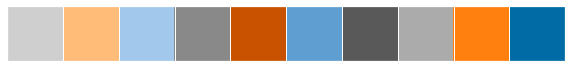

In [3]:
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

In [10]:
top_n_movie_ratings = pd.read_csv('./drive/MyDrive/data-files/top-n-movies_user-ratings.csv'). drop(columns='Unnamed: 0')

In [11]:
top_n_movie_ratings.head()

,user_id,movie_id,rating,movie_title
0,307,0,4,Toy Story
1,250,99,4,Fargo
2,24,180,5,Return of the Jedi
3,19,287,1,Scream
4,31,293,3,Liar Liar


In [12]:
# create a dictionary between movie_id and movie_title (since the results output doesn't have titles)
movie_titles = top_n_movie_ratings.groupby(['movie_id','movie_title']).size().to_frame() \
                                    .reset_index('movie_title').movie_title \
                                    .to_dict()
movie_titles

{0: 'Toy Story',
 49: 'Star Wars',
 99: 'Fargo',
 120: 'Independence Day',
 180: 'Return of the Jedi',
 257: 'Contact',
 285: 'English Patient, The',
 287: 'Scream',
 293: 'Liar Liar',
 299: 'Air Force One'}

In [13]:
color_map = dict(zip(top_n_movie_ratings.movie_title.sort_values().unique().tolist(), color_blind_palette_10))
color_map

{'Air Force One': '#cfcfcf',
 'Contact': '#ffbc79',
 'English Patient, The': '#a2c8ec',
 'Fargo': '#898989',
 'Independence Day': '#c85200',
 'Liar Liar': '#5f9ed1',
 'Return of the Jedi': '#595959',
 'Scream': '#ababab',
 'Star Wars': '#ff800e',
 'Toy Story': '#006ba4'}

In [16]:
ab_test_1k = pd.read_csv('./drive/MyDrive/data-files/ab_test_1k.csv').drop(columns='Unnamed: 0')

In [17]:
ab_test_1k.head()

,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id,visit
0,1.000000,0,299,1,1,767,0
1,1.000000,0,99,1,2,144,1
2,0.666667,0,257,0,2,276,2
3,0.500000,0,180,0,2,907,3
4,0.400000,0,49,0,2,580,4


In [19]:
ab_test_5k = pd.read_csv('./drive/MyDrive/data-files/ab_test_5k.csv').drop(columns='Unnamed: 0')

In [20]:
ab_test_5k.head()

,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id,visit
0,1.000000,0,299,1,1,767,0
1,1.000000,0,99,1,2,144,1
2,0.666667,0,257,0,2,276,2
3,0.500000,0,180,0,2,907,3
4,0.400000,0,49,0,2,580,4


In [22]:
eps_greedy_05 = pd.read_csv('./drive/MyDrive/data-files/epsilon_greedy_05.csv').drop(columns='Unnamed: 0')

In [24]:
eps_greedy_05.head()

,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id,visit
0,1.000000,0,0,1,1,20,0
1,0.500000,0,0,0,1,458,1
2,0.666667,0,0,1,2,921,2
3,0.500000,0,0,0,2,212,3
4,0.400000,0,0,0,2,72,4


In [25]:
eps_greedy_10 = pd.read_csv('./drive/MyDrive/data-files/epsilon_greedy_10.csv').drop(columns='Unnamed: 0')

In [26]:
eps_greedy_10.head()

,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id,visit
0,0.0,0,0,0,0,654,0
1,0.0,0,0,0,0,553,1
2,0.0,0,0,0,0,653,2
3,0.0,0,0,0,0,203,3
4,0.0,0,0,0,0,395,4


In [28]:
thompson = pd.read_csv('./drive/MyDrive/data-files/thompson_sampling.csv').drop(columns='Unnamed: 0')

In [29]:
thompson.head()

,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id,visit
0,0.0,0,120,0,0,114,0
1,0.0,0,0,0,0,885,1
2,0.0,0,49,0,0,868,2
3,0.0,0,99,0,0,593,3
4,0.0,0,285,0,0,586,4


In [30]:
# create a dataframe with running totals of how many times each recommendation was taken
thompson_running_ttl = thompson.query('iteration == 0') \
                                .eval('selected = 1') \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index() \
                                .rename(columns=movie_titles)

In [31]:
# scale the value by the visit number to get turn the running total into a percentage
thompson_running_ttl.iloc[:,1:] = thompson_running_ttl.iloc[:,1:].div((thompson_running_ttl.visit + 1)/100, axis=0)

In [32]:
thompson_running_ttl.head()

item_id,visit,Toy Story,Star Wars,Fargo,Independence Day,Return of the Jedi,Contact,"English Patient, The",Scream,Liar Liar,Air Force One
0,0,0.000000,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,50.000000,0.000000,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,33.333333,33.333333,0.0,33.333333,0.0,0.0,0.0,0.0,0.0,0.0
3,3,25.000000,25.000000,25.0,25.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,20.000000,20.000000,20.0,20.000000,0.0,0.0,20.0,0.0,0.0,0.0


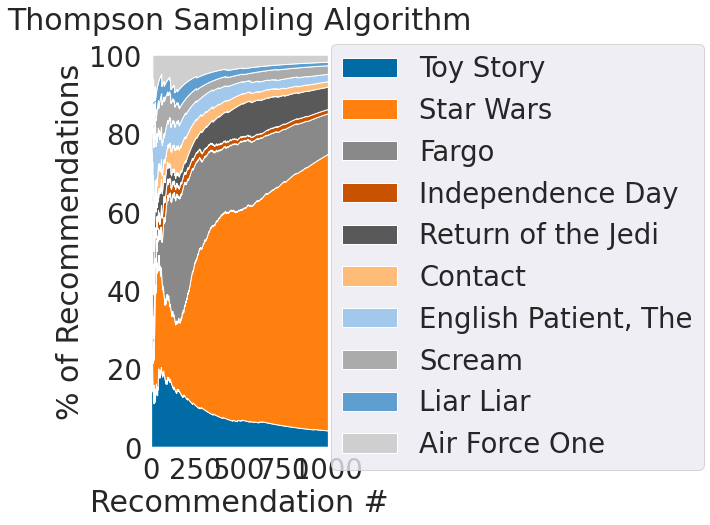

In [37]:
sns.set_palette(color_blind_palette_10)

fig, ax = plt.subplots(figsize=(10,8))

ax.stackplot(thompson_running_ttl.visit,
             thompson_running_ttl.iloc[:,1:11].T,
             labels=thompson_running_ttl.iloc[:,1:11].columns.values.tolist(),
             colors=[color_map[x] for x in thompson_running_ttl.iloc[:,1:].columns.values]
            )

ax.set_xlim(0,1000)
ax.set_xticks(range(0, 1100, 250))

ax.set_title('Thompson Sampling Algorithm')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

lgd = plt.legend(bbox_to_anchor=(1.02, 0.98), loc=2, borderaxespad=0.)

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [41]:
fig.savefig('./drive/MyDrive/data-files/bandit_results.png', transparent=False, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [42]:
ab_test_1k_avg = ab_test_1k.groupby('visit', as_index=False).mean()

In [43]:
ab_test_1k_avg.head()

,visit,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id
0,0,0.3500,9.5,226.40,0.35,0.35,498.80
1,1,0.3500,9.5,160.35,0.35,0.70,559.10
2,2,0.3500,9.5,168.70,0.35,1.05,472.75
3,3,0.3375,9.5,242.25,0.30,1.35,542.90
4,4,0.3300,9.5,188.80,0.30,1.65,553.35


In [44]:
ab_test_5k_avg = ab_test_5k.groupby(['visit'], as_index=False).mean()

In [45]:
ab_test_5k_avg.head()

,visit,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id
0,0,0.300000,9.5,231.80,0.30,0.30,450.75
1,1,0.225000,9.5,199.20,0.15,0.45,418.50
2,2,0.216667,9.5,201.45,0.20,0.65,437.90
3,3,0.250000,9.5,183.00,0.35,1.00,486.85
4,4,0.240000,9.5,186.00,0.20,1.20,437.50


In [46]:
eps_greedy_05_avg = eps_greedy_05.groupby(['visit'], as_index=False).mean()

In [47]:
eps_greedy_05_avg.head()

,visit,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id
0,0,0.250000,9.5,0.00,0.25,0.25,560.60
1,1,0.350000,9.5,12.85,0.45,0.70,423.25
2,2,0.333333,9.5,19.90,0.30,1.00,568.70
3,3,0.300000,9.5,14.95,0.20,1.20,442.15
4,4,0.290000,9.5,29.30,0.25,1.45,490.95


In [48]:
eps_greedy_10_avg = eps_greedy_10.groupby(['visit'], as_index=False).mean()

In [49]:
eps_greedy_10_avg.head()

,visit,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id
0,0,0.300000,9.5,12.85,0.30,0.30,462.55
1,1,0.200000,9.5,20.35,0.10,0.40,438.35
2,2,0.183333,9.5,14.95,0.15,0.55,507.60
3,3,0.175000,9.5,26.65,0.15,0.70,383.10
4,4,0.200000,9.5,14.35,0.30,1.00,594.30


In [50]:
thompson_avg = thompson.groupby(['visit'], as_index=False).mean()

In [51]:
thompson_avg.head()

,visit,fraction_relevant,iteration,item_id,reward,total_reward,visitor_id
0,0,0.3000,9.5,187.60,0.30,0.30,280.45
1,1,0.2750,9.5,176.40,0.25,0.55,445.70
2,2,0.2500,9.5,183.80,0.20,0.75,473.60
3,3,0.2875,9.5,184.60,0.40,1.15,450.35
4,4,0.3100,9.5,184.85,0.40,1.55,391.70


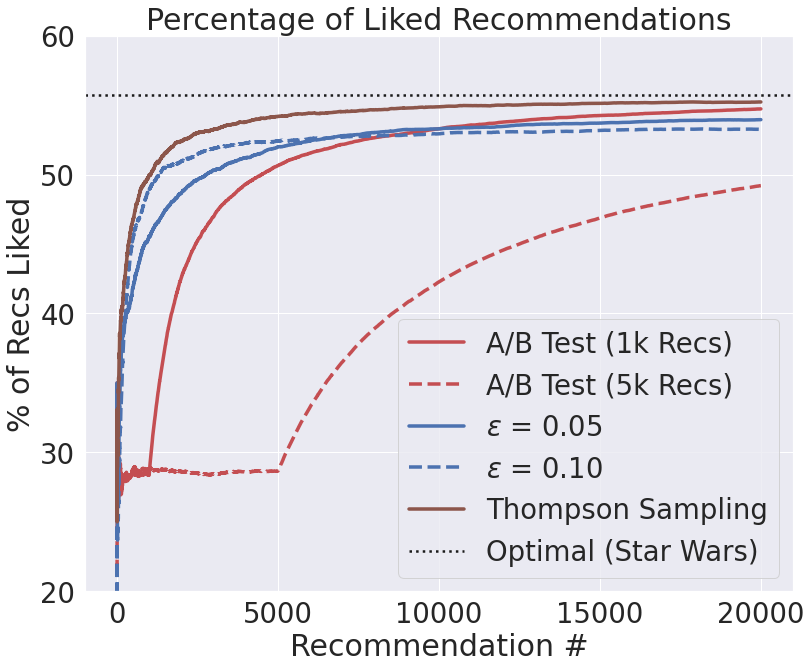

In [52]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_df, style) in [(ab_test_1k_avg, 'r-'),
                                (ab_test_5k_avg, 'r--'),
                                (eps_greedy_05_avg, 'b-'),
                                (eps_greedy_10_avg, 'b--'),
                                (thompson_avg, 'tab:brown')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)

# add a line for the optimal value -- 0.5575 for Star Wars (from exploration noteboook)
ax.axhline(y=0.5575, color='k', linestyle=':', linewidth=2.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0,22000,5000))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.7, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['A/B Test (1k Recs)',
           'A/B Test (5k Recs)',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10',
           'Thompson Sampling',
           'Optimal (Star Wars)'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()
